In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm
import intake
import glob
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',-1)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


Load the signal and noise datasets.  Noise is the estimates of standard deviation from piControl <code>[lon x lat]</code>. Signal is the regression coefficients that relate global mean surface temperature (T<sub>global</sub>, created following Hawkins and Sutton (2012)) to local temperature (local temperature = temperature at each gridpoint).  The regression coefficients, $\alpha$ (slope) and $\beta$ (intercept), have dimensions of <code>[lon x lat]</code>.  We also need to load our T<sub>global</sub> time series. 

In [2]:
modelname = 'BCC-CSM2-MR'
membername = 'r1i1p1f1'
signal_dir = '/glade/u/home/mmcgraw/'
signal_filename = signal_dir + '{modelname}_{membername}_SIGNAL_T_predictions.nc'.format(modelname=modelname,
                                                                                        membername=membername)
S = xr.open_dataset(signal_filename)
noise_dir = '/glade/u/home/molina/'
noise_data = xr.open_dataset(noise_dir+'piControl_demonthlied.nc')

Now, we pull out our signal (T_predict) and calculate the noise.  We just take the standard deviation of the piControl temperature data. 

In [3]:
N = noise_data['tas'].std('time')
T_local = S['T_predict']
yrs = S['time.year'] #we need this for plotting later
#print(yrs)
S

<xarray.Dataset>
Dimensions:    (lat: 160, lon: 320, time: 1211)
Coordinates:
    height     float64 ...
    alpha      (lon, lat) float64 ...
    beta       (lon, lat) float64 ...
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * time       (time) object 2000-01-16 12:00:00 ... 2100-11-16 00:00:00
    month      (time) int64 ...
Data variables:
    T_predict  (time, lon, lat) float64 ...
    Tglobal    (time) float64 ...

Now, we create the signal to noise ratio--we simply divide our T predictions by our standard deviation of temperature.  Plot the signal to noise ratio at two time slices (beginning and end) as a sanity check

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  """


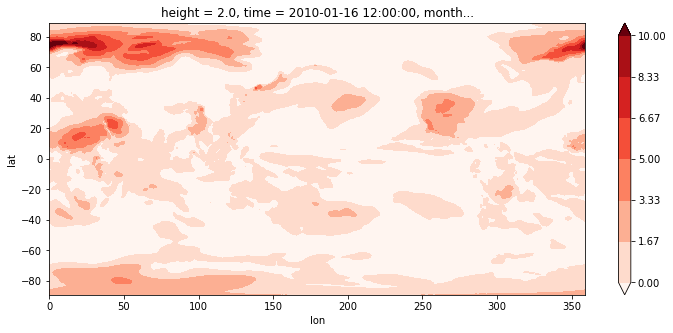

In [4]:
sig_to_noise = T_local/N
#ax1 = plt.axes(projection=ccrs.Robinson())
#txx = sig_to_noise.isel(time=slice(0,72)).mean(dim='time')
#print(txx)
sig_to_noise.isel(time=120).transpose().plot.contourf(vmin=0,vmax=10,cmap='Reds')
plt.gcf().set_size_inches((12,5))

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


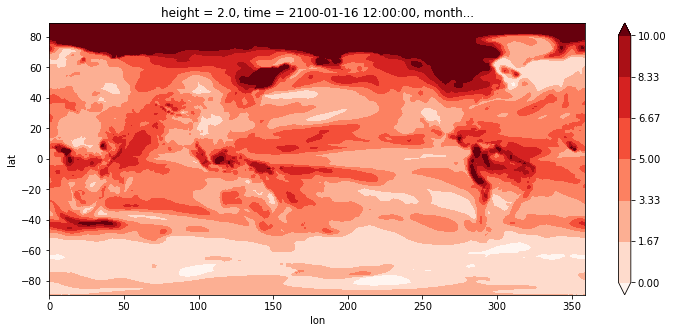

In [5]:
#and now at end of period
sig_to_noise.isel(time=1200).transpose().plot.contourf(vmin=0,vmax=10,cmap='Reds')
plt.gcf().set_size_inches((12,5))

Now, we determine the time of emergence--when does the signal to noise ratio exceed some threshold? We decide that <b> time of emergence </b> is the first year in which some signal-to-noise ratio exceeds a threshold that we set.  We estimate this first year for each gridpoint, which provides an output array with dimensions of <code>[lon x lat]</code>.  The values in the ToE array will be in units of years. 

In [6]:
years = yrs
template = S['T_predict'].isel(time=0).data
toe_s = np.zeros_like(template)

toe_das = []
ratios = 1, 2, 3
for ratio in ratios:
    toe_s = np.zeros_like(template)
    for iyear in np.arange(0,len(years)):
        yr_act = years[iyear]
        _sn_year = sig_to_noise.isel(time=iyear).data
        toe_s[(toe_s == 0) & (_sn_year > ratio)] = yr_act
        
    # Mask out zeros
    toe_s = np.ma.masked_equal(toe_s, 0)
    toe_da = xr.DataArray(toe_s, 
                          dims=['lon', 'lat'], 
                          coords=[sig_to_noise.lon, sig_to_noise.lat])
    toe_das.append(toe_da)

toe_ds = xr.concat(toe_das, dim=pd.Index(ratios, name='ratio'))
toe_ds.name = 'TOE'
#sn_ds['TOE'] = toe_ds
print(toe_ds)

<xarray.DataArray 'TOE' (ratio: 3, lon: 320, lat: 160)>
array([[[2000., 2000., 2000., ..., 2000., 2000., 2000.],
        [2000., 2000., 2000., ..., 2000., 2000., 2000.],
        [2000., 2000., 2000., ..., 2000., 2000., 2000.],
        ...,
        [2000., 2000., 2000., ..., 2000., 2000., 2000.],
        [2000., 2000., 2000., ..., 2000., 2000., 2000.],
        [2000., 2000., 2000., ..., 2000., 2000., 2000.]],

       [[2001., 2001., 2001., ..., 2000., 2000., 2000.],
        [2001., 2001., 2001., ..., 2000., 2000., 2000.],
        [2001., 2001., 2001., ..., 2000., 2000., 2000.],
        ...,
        [2001., 2001., 2001., ..., 2000., 2000., 2000.],
        [2001., 2001., 2001., ..., 2000., 2000., 2000.],
        [2001., 2001., 2001., ..., 2000., 2000., 2000.]],

       [[2002., 2002., 2002., ..., 2000., 2000., 2000.],
        [2002., 2002., 2002., ..., 2000., 2000., 2000.],
        [2002., 2002., 2002., ..., 2000., 2000., 2000.],
        ...,
        [2002., 2002., 2002., ..., 2000., 2000

Finally, we can plot the time of emergence as a function of gridpoint. 

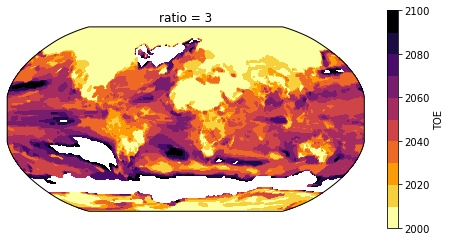

In [7]:
fig1 = plt.figure()
ax1 = plt.axes(projection=ccrs.Robinson())
ax1.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())
ratio_sel = 3
toe_plot = toe_ds.sel(ratio=ratio_sel).transpose()
lon = toe_plot['lon']
lat = toe_plot['lat']
cp1 = toe_plot.plot.contourf(ax=ax1,levels=11,vmin=2000,vmax=2100,transform=ccrs.PlateCarree(),cmap='inferno_r')
#fig1.colorbar(pad=0.05,extend='both')
#ax1.coastlines()
plt.gcf().set_size_inches((8,4))